Membaca dataset menggunakan `rasterio` untuk membaca dataset dengan format file `.tif`

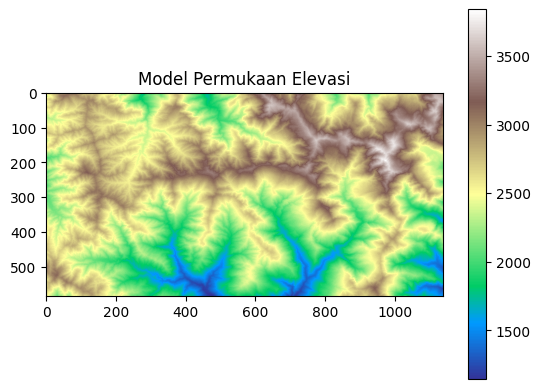

In [8]:
import rasterio
import matplotlib.pyplot as plt

with rasterio.open('dataset.tif') as src:
    elevasi = src.read(1)  # Membaca band pertama sebagai data elevasi
    plt.imshow(elevasi, cmap='terrain')
    plt.colorbar()
    plt.title('Model Permukaan Elevasi')
    plt.show()


Memeriksa metadata dari dataset menggunakan `rasterio`

In [9]:
with rasterio.open('dataset.tif') as src:
    print(src.meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1138, 'height': 583, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002778321616871635, 0.0, 77.222148,
       0.0, -0.0002778593481989734, 31.598841)}


Mengambil koordinat elevasi

In [10]:
import numpy as np

with rasterio.open('dataset.tif') as src:
    elevasi = src.read(1)  # Data elevasi
    transform = src.transform
    
    # Mendapatkan koordinat X dan Y untuk grid
    rows, cols = elevasi.shape
    x_coords, y_coords = np.meshgrid(
        np.arange(cols), np.arange(rows)
    )
    
    # Mengubah indeks grid menjadi koordinat geografis
    x_coords_geo, y_coords_geo = rasterio.transform.xy(transform, y_coords, x_coords, offset='center')

Interpolasi Grid dari Dataset dari data yang sudah dibaca dari `rasterio` dan memprosesnya menggunakan `scipy.interpolate.griddata`.

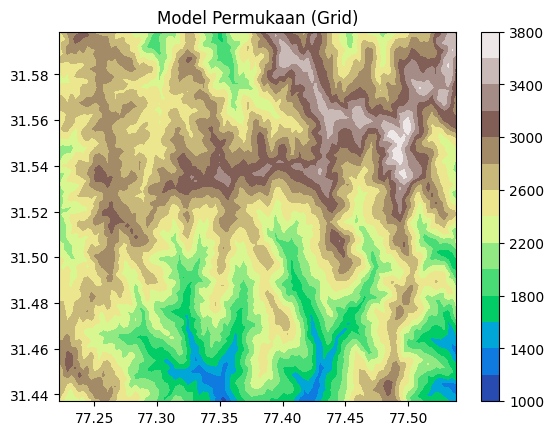

In [11]:
from scipy.interpolate import griddata
import numpy as np

# Mengonversi data menjadi grid
grid_x, grid_y = np.mgrid[min(x_coords_geo):max(x_coords_geo):100j, min(y_coords_geo):max(y_coords_geo):100j]

# Interpolasi IDW dengan metode linear
grid_z = griddata((x_coords_geo, y_coords_geo), elevasi.flatten(), (grid_x, grid_y), method='linear')

# Visualisasi grid hasil interpolasi
plt.contourf(grid_x, grid_y, grid_z, levels=15, cmap='terrain')
plt.colorbar()
plt.title('Model Permukaan (Grid)')
plt.show()


Menerapkan **TIN (Triangulated Irregular Network)** menggunakan `scipy.spatial.Delaunay`.

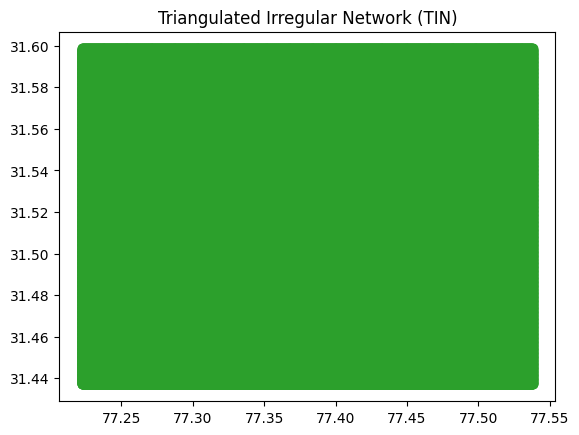

In [12]:
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt

# Membuat triangulasi Delaunay berdasarkan koordinat X dan Y
points = np.c_[x_coords_geo, y_coords_geo]
tri = Delaunay(points)

# Visualisasi hasil triangulasi
plt.triplot(x_coords_geo, y_coords_geo, tri.simplices)
plt.plot(x_coords_geo, y_coords_geo, 'o')
plt.title('Triangulated Irregular Network (TIN)')
plt.show()

Menghitung kemiringan dan aspek dari data yang sudah diekstrak dari file GeoTIFF

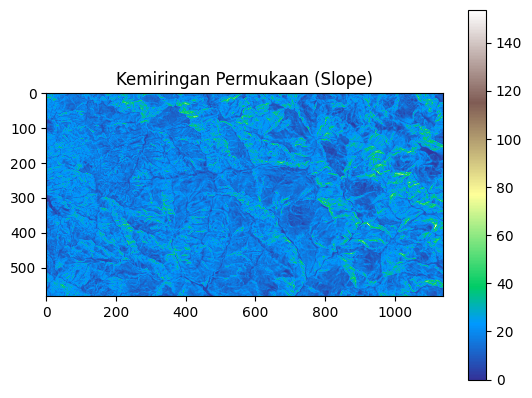

In [13]:
dz_dx, dz_dy = np.gradient(elevasi)

# Menghitung kemiringan (slope)
slope = np.sqrt(dz_dx**2 + dz_dy**2)

# Visualisasi kemiringan
plt.imshow(slope, cmap='terrain')
plt.colorbar()
plt.title('Kemiringan Permukaan (Slope)')
plt.show()

Menghitung aspek dengan menggunakan `arctan` untuk mendapatkan orientasi kemiringan permukaan.

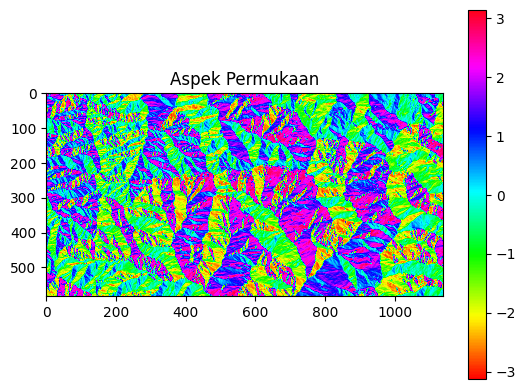

In [14]:
aspect = np.arctan2(dz_dy, dz_dx)
plt.imshow(aspect, cmap='hsv')
plt.colorbar()
plt.title('Aspek Permukaan')
plt.show()